In [1]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import xgboost as xgb

# Boston house prices with XGBoost (regression)

This is a copy of UCI ML housing dataset. https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. ‘Hedonic prices and the demand for clean air’, J. Environ. Economics & Management, vol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch, ‘Regression diagnostics …’, Wiley, 1980. N.B. Various transformations are used in the table on pages 244-261 of the latter.

Source of project:
https://www.datacamp.com/community/tutorials/xgboost-in-python

In [2]:
# Import Boston dataset

from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
# the boston variable is a dictionary which contains the data
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [4]:
print("shape of the data:", boston.data.shape)
print("features of the data:", boston.feature_names)

shape of the data: (506, 13)
features of the data: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [5]:
# The description of the dataset
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
# The price is not included in the boston.data
data['PRICE'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


#### If you have some missing values such as NA in the dataset you may or may not do a separate treatment for them, because XGBoost is capable of handling missing values internally.

In [8]:
# Basic statistics of the data
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [9]:
# Separate the target and rest of the variables
X, y = data.iloc[:,:-1],data.iloc[:,-1]

In [10]:
# convert the dataset into an optimized data structure called Dmatrix
# that XGBoost supports and gives it acclaimed performance and efficiency gains
data_dmatrix = xgb.DMatrix(data=X,label=y)

## XGBoost's hyperparameters


- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- alpha: L1 regularization on leaf weights. A large value leads to more regularization.
- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.



In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)


In [13]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [14]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 10.496021


## k-fold Cross Validation using XGBoost

XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:

 - num_boost_round: denotes the number of trees you build (analogous to n_estimators)
 - metrics: tells the evaluation metrics to be watched during CV
 - as_pandas: to return the results in a pandas DataFrame.
 - early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
 - seed: for reproducibility of results.


In [15]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [16]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.679235,0.025628,21.677615,0.050615
1,19.772295,0.016055,19.773320,0.020568
2,18.049566,0.058903,18.065856,0.082746
3,16.430114,0.013613,16.492197,0.020920
4,15.025979,0.062131,15.132644,0.073106


In [17]:
# final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    3.975679
Name: test-rmse-mean, dtype: float64


### Visualize Boosting Trees and Feature Importance

You can also visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset. XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

In [18]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

If this code throws the 'graphviz' error, consider installing the graphviz package via <b> pip install graphviz </b>. You may also need to run <b>sudo apt-get install graphviz </b> on command line

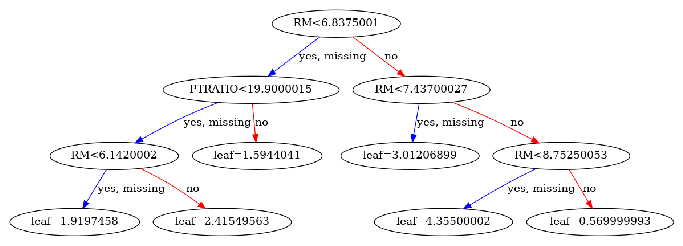

In [33]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this.

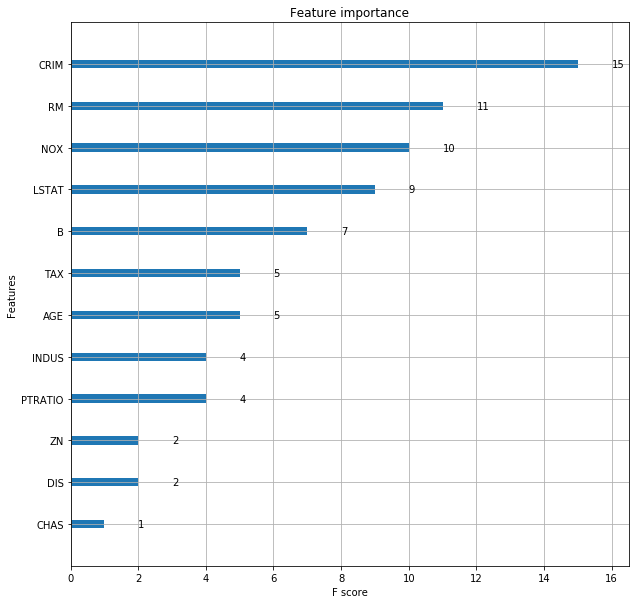

In [20]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Detecting Parkinson’s Disease with XGBoost (classification)

Parkinson’s disease is a progressive disorder of the central nervous system affecting movement and inducing tremors and stiffness. It has 5 stages to it and affects more than 1 million individuals every year in India. This is chronic and has no cure yet. It is a neurodegenerative disorder affecting dopamine-producing neurons in the brain.

Source for this project:
https://data-flair.training/blogs/python-machine-learning-project-detecting-parkinson-disease/

### Data
The dataset was created by Max Little of the University of Oxford, in collaboration with the National Centre for Voice and Speech, Denver, Colorado, who recorded the speech signals. The original study published the feature extraction methods for general voice disorders.

This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD.

The data is in ASCII CSV format. The rows of the CSV file contain an instance corresponding to one voice recording. There are around six recordings per patient, the name of the patient is identified in the first column.For further information or to pass on comments, please contact Max Little (littlem '@' robots.ox.ac.uk). 

https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/

Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear).


In [21]:
# Read the data to a Pandas dataframe
df = pd.read_csv(os.path.join(".","data", "parkinsons.data"))
print("shape of dataframe:", df.shape)
df.head()

shape of dataframe: (195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


### Attribute Information:

Matrix column entries (attributes):
- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency
- MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice
- status - Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE,D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

In [22]:
# Get the features and labels
features = df.drop(columns = ['status', 'name']).values

labels = df.loc[:,'status'].values

print("shape of features:", features.shape)
print("features")
print(features, "\n")

print("shape of labels:", labels.shape)
print("labels")
print(labels)

shape of features: (195, 22)
features
[[1.199920e+02 1.573020e+02 7.499700e+01 ... 2.664820e-01 2.301442e+00
  2.846540e-01]
 [1.224000e+02 1.486500e+02 1.138190e+02 ... 3.355900e-01 2.486855e+00
  3.686740e-01]
 [1.166820e+02 1.311110e+02 1.115550e+02 ... 3.111730e-01 2.342259e+00
  3.326340e-01]
 ...
 [1.746880e+02 2.400050e+02 7.428700e+01 ... 1.584530e-01 2.679772e+00
  1.317280e-01]
 [1.987640e+02 3.969610e+02 7.490400e+01 ... 2.074540e-01 2.138608e+00
  1.233060e-01]
 [2.142890e+02 2.602770e+02 7.797300e+01 ... 1.906670e-01 2.555477e+00
  1.485690e-01]] 

shape of labels: (195,)
labels
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0]


In [23]:
# Get the count of each label (0 and 1) in labels
print("number of 1s in labels:", labels[labels==1].shape[0])
print("number of 0s in labels:", labels[labels==0].shape[0])

number of 1s in labels: 147
number of 0s in labels: 48


In [24]:
# Scale the features to between -1 and 1
scaler = MinMaxScaler((-1,1))
x = scaler.fit_transform(features)
y = labels

In [25]:
# Split the dataset
# 80% in train, 20% in test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [26]:
# Train the model
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
# Calculate the accuracy on test set
y_pred = model.predict(x_test)
print("accuracy:", round(accuracy_score(y_test, y_pred)*100, 3))

accuracy: 94.872
